In [1]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# We always use mean and ast calculated on trainset
# calculating it on val or train lead to data leakage

mean, std = [8.489298], [9.06547]

train_transforms = A.Compose(
    [   
        A.Normalize(mean, std),
        A.RandomCrop(192, 192),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [   
        A.Normalize(mean, std),
        A.CenterCrop(192, 192),
        ToTensorV2(),
    ]
)

class NormalizeNonZero(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, x):
        mask = x == 0
        x -= self.mean
        x /= self.std
        x[mask] = 0
        return x.to(torch.float32)
    
    def denorm(self,x):
        mask = x == 0
        x *=  self.std
        x += self.mean
        x[mask] = 0
        return x

#Normalization by the whole (non-dotted) mask
#target_mean, target_std = 1.7816125217702499, 2.170761470939972
#nnz = NormalizeNonZero(target_mean, target_std)

#Normalization by the dotted mask
dot_target_mean, dot_target_std = 3.016509424749255, 2.452459479074767
nnz = NormalizeNonZero(dot_target_mean, dot_target_std)


target_transform = T.Compose([nnz])


In [2]:
import os
import pickle
%load_ext autoreload
%autoreload 2

from dataset2chdm import CustomDataset2chdm

def load_cache(filename = "cachedm.pickle"):
      if os.path.isfile(filename):
        with open(filename, 'rb') as f:
           cache =  pickle.load(f)
        print(f"Loaded cache from {filename}")
        return cache
      return None
cache = load_cache()

Loaded cache from cachedm.pickle


In [4]:
ds_train = CustomDataset2chdm("Splitted Dataset/Train", transform  = train_transforms, target_transform = target_transform, cache = cache)
loader_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=2)
#ds_train = CustomDataset("Splitted Dataset/Train")

ds_val = CustomDataset2chdm("Splitted Dataset/Val", transform  = val_transforms, target_transform=target_transform, cache = cache)
loader_val = DataLoader(ds_val, batch_size=4, shuffle=False, num_workers=2)
#ds_val = CustomDataset("Splitted Dataset/Val")

ds_test = CustomDataset2chdm("Splitted Dataset/Test", transform  = val_transforms, target_transform=target_transform, cache = cache)
loader_test = DataLoader(ds_test, batch_size=4, shuffle=False, num_workers=2)
#ds_test = CustomDataset("Splitted Dataset/Test")

In [3]:
'''
def get_mean_and_std(ds):
    loader = DataLoader(ds, batch_size=32, shuffle=False)  # max batch_size
    batch_mean = []  # list of batch_mean
    batch_std = []
    batch_target_mean = []
    batch_target_std = []

    for _, im, mask, meta in tqdm(loader):
        batch_mean.append(im.mean((0,2,3)))  # batch_size x C, H x W
        batch_std.append(im.std((0,2,3)))
        mask_non_zero = mask[mask != 0].flatten()
        batch_target_mean.append(mask_non_zero.mean())
        batch_target_std.append(mask_non_zero.std())
    mean = np.stack(batch_mean).mean(0)  #
    std = np.stack(batch_std).mean(0)
    target_mean = np.stack(batch_target_mean).mean(0)  #
    target_std = np.stack(batch_target_std).mean(0)
    return mean, std,  target_mean,  target_std

train_transforms2 = A.Compose(
    [   
        A.Resize(512,512),
        ToTensorV2(),
    ]
)
ds_train = CustomDataset2chdm("Splitted Dataset/Train")
ds_train.transform = train_transforms2
mean, std, target_mean, target_std = get_mean_and_std(ds_train)

print(mean, std, target_mean, target_std)
'''    

TypeError: where() received an invalid combination of arguments - got (numpy.ndarray, int, int), but expected one of:
 * (Tensor condition)
 * (Tensor condition, Tensor input, Tensor other, *, Tensor out)
 * (Tensor condition, Number self, Tensor other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)
 * (Tensor condition, Tensor input, Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)
 * (Tensor condition, Number self, Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)


In [6]:
#ds_train.save_cache()

In [7]:
from torchmetrics import MeanSquaredError
from typing import Any, Optional, Sequence, Union
from torch import Tensor

class ZeroAwareMSE(MeanSquaredError):
    def update(self, preds: Tensor, target: Tensor) -> None:
        target_sum = torch.sum(target).item()
        if target_sum == 0:#change preds and targets in such a way that the result would be zero tensor (not works directly) 
            preds = preds - preds + 1
            target = target + 1
        mask = target != 0
        return super().update(preds[mask],target[mask])
'''
class ZeroAwareMSE(MeanSquaredError):
    def update(self, preds: Tensor, target: Tensor) -> None:
        mask = target != 0
        return super().update(preds[mask],target[mask])
'''
        #count_nonzero(pred[mask], dim=None)

'\nclass ZeroAwareMSE(MeanSquaredError):\n    def update(self, preds: Tensor, target: Tensor) -> None:\n        mask = target != 0\n        return super().update(preds[mask],target[mask])\n'

In [8]:
def MSELoss_mask(pred, target): #MSE loss calculated only inside the masks (which are contained in the targets)
  mse_loss = MSELoss(reduction='sum')  #calculates sum of the squared errors (without division by n)
  loss = mse_loss(pred, target) #calculates sum of the squared errors (without division by n)
  target_binary = torch.where(target != 0, 1, 0) #writing 1 in each unmasked pixel and 0 in each masked pixel (for calculation the number of unmasked pixels)
  n_ummasked_pxls = target_binary.sum()#.item() #calculating the number of unmasked pixels
  if n_ummasked_pxls == 0:
    return 0

  return loss/n_ummasked_pxls

import torch.nn as nn

class CustomLoss(nn.Module):
  def __init__(self):
    super(CustomLoss, self).__init__()

  def forward(self, pred, target):
    return MSELoss_mask(pred, target)

In [9]:
import lightning as L
from torchmetrics import MeanSquaredError
from torch.nn import MSELoss
import torch

class Lit(L.LightningModule):
    def __init__(self, model, lr=0.0025):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = CustomLoss()
        self.save_hyperparameters()
        self.metric_train = ZeroAwareMSE()
        self.metric_train_dn = ZeroAwareMSE()
        self.metric_val = ZeroAwareMSE()
        self.metric_val_dn = ZeroAwareMSE()
        self.metric_test = ZeroAwareMSE()
        self.metric_test_dn = ZeroAwareMSE()  #??

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        _, imgs, masks, meta = batch
        predicted_masks = self.get_prediction(batch)
        #print(predicted_masks, masks)
        loss = self.criterion(predicted_masks, masks)
        #loss_dn = self.criterion(nnz.denorm(predicted_masks), nnz.denorm(masks))
        self.log("Loss/", loss.item(), prog_bar=False)
        #self.log("Loss_dn/", loss_dn.item(), prog_bar=False)
        self.metric_train.update(predicted_masks, masks)
        #self.metric_train_dn.update(nnz.denorm(predicted_masks), nnz.denorm(masks))
        return loss

    def get_prediction(self,batch):
        im_masks, imgs, masks, meta = batch
        predicted_masks = self.model(im_masks).squeeze(1)
        predicted_masks = self.postprocess(predicted_masks, masks)
        return predicted_masks

    def postprocess(self, pred, mask):
        pred = pred.squeeze(1)
        pred[mask == 0] = 0
        return pred

    def validation_step(self, batch, batch_idx):
        _, imgs, masks, meta = batch
        predicted_masks = self.get_prediction(batch)
        self.metric_val.update(predicted_masks, masks)
        self.metric_val_dn.update(nnz.denorm(predicted_masks), nnz.denorm(masks))

    def on_validation_epoch_end(self):
        self.log("MSE/val", self.metric_val.compute(), prog_bar=True)
        self.log("MSE/val_dn", self.metric_val_dn.compute(), prog_bar=True)
        self.metric_val.reset()
        self.metric_val_dn.reset()

    def on_train_epoch_end(self):
        self.log("MSE/train", self.metric_train.compute())
        #self.log("MSE_dn/train", self.metric_train_dn.compute())
        self.metric_train.reset()

    def test_step(self, batch, batch_idx):
        im_masks, imgs, masks, _ = batch
        predicted_masks = self.get_prediction(batch)
        self.log("MSE/test", self.metric_test.compute(), prog_bar=True)
        self.metric_test.update(predicted_masks, masks)
        self.metric_test_dn.update(nnz.denorm(predicted_masks), nnz.denorm(masks))#??

    def on_test_epoch_end(self):
        self.log("MSE/test", self.metric_test.compute(), prog_bar=True)
        self.log("MSE/test_dn", self.metric_test_dn.compute(), prog_bar=True)
        self.metric_test.reset()
        self.metric_test_dn.reset()

In [10]:
import segmentation_models_pytorch as smp

smp_unet = smp.Unet(
    encoder_name="efficientnet-b0",  # choose encoder
    encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=2,  # model input channels 3 for RGB
    classes=1,  # model output channels (number of classes in mask)
)

In [11]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='MSE/val',
    #monitor='MSE/train',
    dirpath='lightning_logs',
    #filename='sample-mnist-{epoch:02d}-{val_loss:.2f}',
    save_top_k=5,
    mode='min',
    #every_n_epochs=10
)

lit_model = Lit(smp_unet)

#To continue from checkpoint:
#lit_model = Lit.load_from_checkpoint("/home/jupyter/datasphere/project/lightning_logs/epoch=361-step=4344.ckpt")
#model = lit_model.model
#model.train()

logger = TensorBoardLogger("lightning_logs", name="SMPUnet")
trainer = L.Trainer(
    max_epochs=1000,
    logger=logger,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback]
)  # def on_validation_epoch_start(self):

/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model=lit_model,
            train_dataloaders=loader_train,
            val_dataloaders=loader_val
           )

2024-11-18 06:39:55.936544: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 06:39:57.091375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 06:40:00.765529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jupyter/work/resources/lightning_logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      

Epoch 0: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, v_num=99]         
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:01<00:00,  7.11it/s, v_num=99, MSE/val=1.680, MSE/val_dn=10.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:01<00:00,  6.89it/s, v_num=99, MSE/val=1.690, MSE/val_dn=10.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:01<00:00,  7.00it/s, v_num=99, MSE/val=1.680, MSE/val_dn=10.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:01<00:00,  6.93it/s, v_num=99, MSE/val=1.690, MSE/val_dn=10.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 12/12 [00:01<00:00,  7.00it/s, v_num=99, MSE/val=1.680, MSE/val_dn=10.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 12/12 [00:01<00:00,  7.01it/s, v_num=99, MSE/val=1.680, MSE/val_dn=10.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Ep

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s, v_num=99, MSE/val=0.954, MSE/val_dn=5.740]


In [13]:
trainer.test(model=lit_model, dataloaders=loader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:  80%|████████  | 4/5 [00:00<00:00, 45.38it/s]

/home/jupyter/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric ZeroAwareMSE was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 31.18it/s]


/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         MSE/test          │    0.6496436595916748     │
│        MSE/test_dn        │    3.9073188304901123     │
└───────────────────────────┴───────────────────────────┘

[{'MSE/test': 0.6496436595916748, 'MSE/test_dn': 3.9073188304901123}]

In [14]:
trainer.save_checkpoint(f"lightning_logs{os.sep}last_epoch_checkpoint.ckpt")
smp_unet.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      2, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [15]:
#model = lit_model1.model
#model.eval()
im_masks, img, mask, meta = ds_test[0]
pred = smp_unet(im_masks.unsqueeze(0))
d_pred = nnz.denorm(pred)
d_pred = d_pred.squeeze(0).squeeze(0)
#d_pred[mask ==0] =0
d_mask = nnz.denorm(mask)

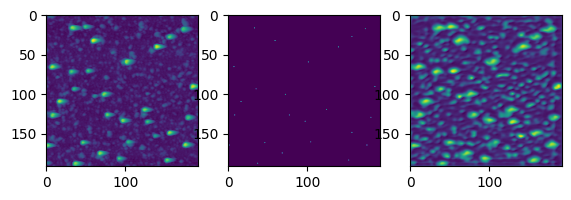

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
ttt1 = img.squeeze(0).detach().cpu().numpy()
plt.subplot(1,4,1)
ttt1 = plt.imshow(ttt1)
ttt2 = d_mask.squeeze(0).detach().cpu().numpy()
plt.subplot(1,4,2)
ttt2 = plt.imshow(ttt2)
ttt3 = d_pred.squeeze(0).detach().cpu().numpy()
plt.subplot(1,4,3)
ttt3 = plt.imshow(ttt3)

In [17]:
import ast
def get_dotted_cropped_test_mask(flnm):
    root_dir = "Splitted Dataset/Test"
    path = f"{root_dir}{os.sep}Masks{os.sep}_{flnm}.txt"
    with open(path, 'r') as file:
        content = file.read()
        x = ast.literal_eval(content)
        x = np.array(x)
    return x

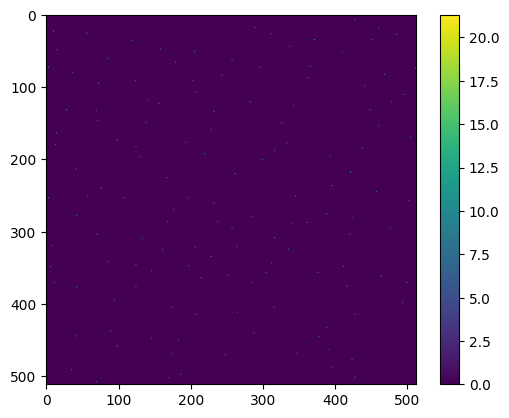

In [18]:
flnm = meta['name']
dotted_mask = get_dotted_cropped_test_mask(flnm)
im = plt.imshow(dotted_mask)
plt.colorbar(im)

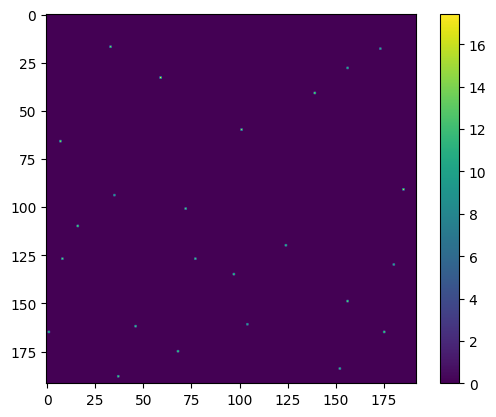

In [19]:
t = torch.from_numpy(dotted_mask)
center_crop = [A.CenterCrop(192, 192)(image = t)]
ten_cr = center_crop[0]['image']
crim = plt.imshow(ten_cr)
plt.colorbar(crim)

In [20]:
zmse = ZeroAwareMSE()
aaaa=zmse(d_pred,ten_cr)
print(aaaa.item())

9.024115562438965


In [21]:
#
#
#

dot_mse = []
for item in ds_test:
    im_masks, img, mask, meta = item
    pred = smp_unet(im_masks.unsqueeze(0))
    d_pred = nnz.denorm(pred)
    d_pred = d_pred.squeeze(0).squeeze(0)
    #d_pred[mask ==0] =0
    d_mask = nnz.denorm(mask)
    flnm = meta['name']
    dotted_mask = get_dotted_cropped_test_mask(flnm)
    t = torch.from_numpy(dotted_mask)
    center_crop = [A.CenterCrop(192, 192)(image = t)]
    ten_cr = center_crop[0]['image']
    zmse = ZeroAwareMSE()
    dot_mse.append(zmse(d_pred,ten_cr).item())
print("Mean dotted MSE on test =", np.mean(dot_mse))


Mean dotted MSE on test = 2.795171432669425


In [22]:
dot_mse

[9.024115562438965,
 5.291830539703369,
 6.312706470489502,
 6.338964462280273,
 3.619284152984619,
 1.7544227838516235,
 3.4971680641174316,
 2.581505537033081,
 2.5783753395080566,
 4.691481113433838,
 4.329358125687577e-05,
 1.7357922792434692,
 0.9335543513298035,
 0.6443144083023071,
 0.0030895648524165154,
 0.526569128036499,
 0.6142847537994385,
 0.16558398306369781]

In [23]:
def get_dotted_cropped_val_mask(flnm):
    root_dir = "Splitted Dataset/Val"
    path = f"{root_dir}{os.sep}Masks{os.sep}_{flnm}.txt"
    with open(path, 'r') as file:
        content = file.read()
        x = ast.literal_eval(content)
        x = np.array(x)
    return x

In [24]:
dot_mse = []
for item in ds_val:
    im_masks, img, mask, meta = item
    pred = smp_unet(im_masks.unsqueeze(0))
    d_pred = nnz.denorm(pred)
    d_pred = d_pred.squeeze(0).squeeze(0)
    #d_pred[mask ==0] =0
    d_mask = nnz.denorm(mask)
    flnm = meta['name']
    dotted_mask = get_dotted_cropped_val_mask(flnm)
    t = torch.from_numpy(dotted_mask)
    center_crop = [A.CenterCrop(192, 192)(image = t)]
    ten_cr = center_crop[0]['image']
    zmse = ZeroAwareMSE()
    dot_mse.append(zmse(d_pred,ten_cr).item())
print("Mean dotted MSE on val =", np.mean(dot_mse))

Mean dotted MSE on val = 4.5289600904171285
